In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import sklearn
import holidays

import warnings
warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)
plt.rcParams["figure.figsize"] = (20,8)

In [2]:
import matplotlib.pyplot as plt

def plot_hour_weekday_mae(models: dict):
    """
    Plot hourly and weekday MAE for multiple model result DataFrames.

    Args:
        models (dict): Dictionary where keys are model labels (str) and values are DataFrames
                       containing columns: ['error'], indexed by datetime.
    """

    hourly_mae = {}
    weekday_mae = {}
    hourly_mae_real = {}
    weekday_mae_real = {}

    # Compute grouped errors
    for label, df in models.items():
        df = df.copy()
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek
        hourly_mae[label] = df.groupby('hour')['error'].mean()
        weekday_mae[label] = df.groupby('day_of_week')['error'].mean()
        hourly_mae_real[label] = df.groupby('hour')['abs_error'].mean()
        weekday_mae_real[label] = df.groupby('day_of_week')['abs_error'].mean()


    # --- Hour of Day Plot ---
    plt.figure(figsize=(12, 5))
    for label, mae in hourly_mae.items():
        plt.plot(mae.index, mae.values, marker='o', label=label)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Mean Error (kW)')
    plt.title('Mean Forecast Error by Hour of Day')
    plt.xticks(range(24))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

        # --- Hour of Day Plot ---
    plt.figure(figsize=(12, 5))
    for label, mae in hourly_mae_real.items():
        plt.plot(mae.index, mae.values, marker='o', label=label)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Mean Error (kW)')
    plt.title('Mean Forecast Error by Hour of Day')
    plt.xticks(range(24))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Weekday Plot ---
    plt.figure(figsize=(12, 5))
    for label, mae in weekday_mae.items():
        plt.plot(mae.index, mae.values, marker='o', label=label)
    plt.xlabel('Day of the Week')
    plt.ylabel('Mean Error (kW)')
    plt.title('Mean Forecast Error by Day of the Week')
    plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

        # --- Weekday Plot ---
    plt.figure(figsize=(12, 5))
    for label, mae in weekday_mae_real.items():
        plt.plot(mae.index, mae.values, marker='o', label=label)
    plt.xlabel('Day of the Week')
    plt.ylabel('Mean Error (kW)')
    plt.title('Mean Forecast Error by Day of the Week')
    plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
from google.colab import files
uploaded = files.upload()

Saving BEITEM_temp_data_updated_final (2).csv to BEITEM_temp_data_updated_final (2).csv
Saving combined_power_data_dottenijs_hourly.csv to combined_power_data_dottenijs_hourly.csv


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18413 entries, 2023-01-01 00:00:00 to 2025-02-06 04:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   18413 non-null  float64
dtypes: float64(1)
memory usage: 287.7 KB
None
                     Price
datetime                  
2023-01-01 00:00:00  136.0
2023-01-01 01:00:00  136.0
2023-01-01 02:00:00  136.0
2023-01-01 03:00:00  134.0
2023-01-01 04:00:00  136.0


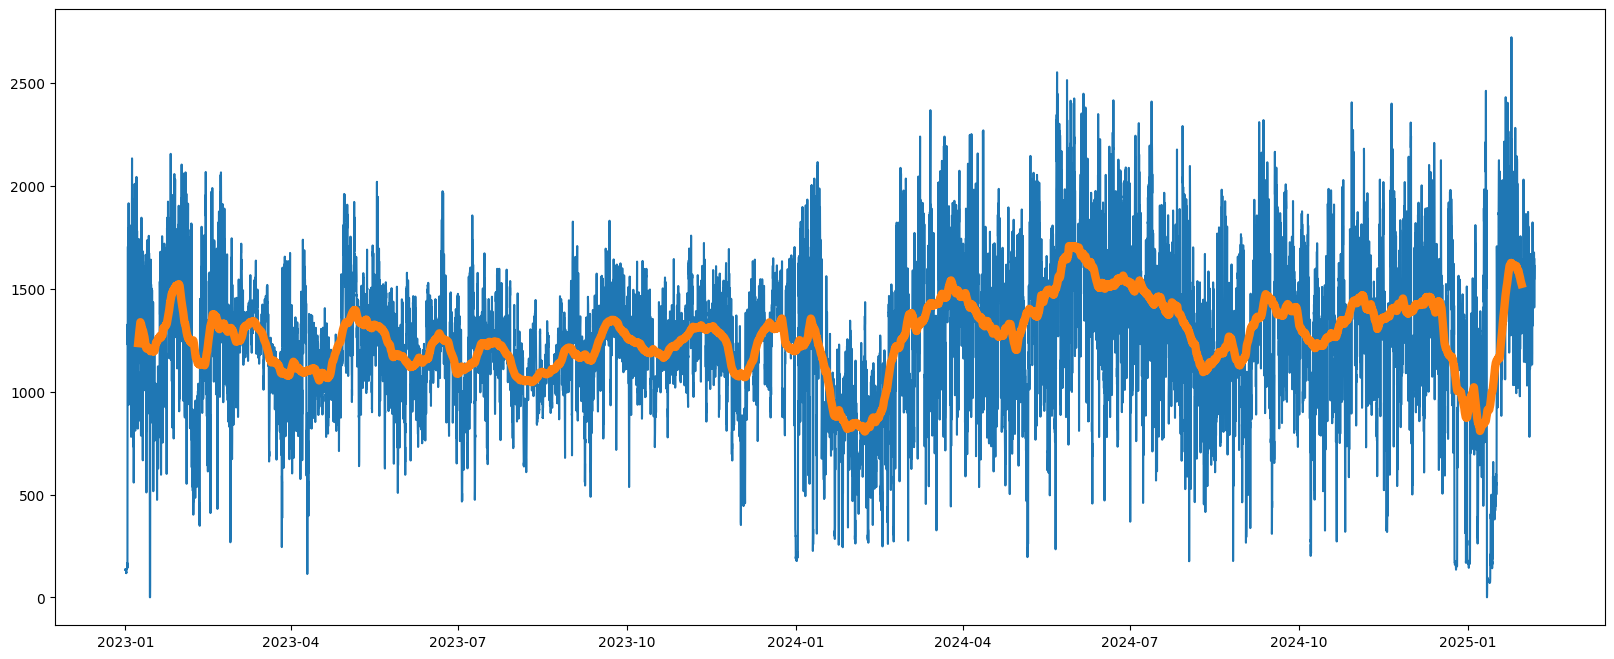

In [4]:
#############################################
# 1. Load and Prepare Data
#############################################

# Load data
df = pd.read_csv('combined_power_data_dottenijs_hourly.csv')

# Convert to datetime and set index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.rename(columns={'Power_Consumption_dottenijs_23-24': 'power'}, inplace=True)
# Check data summary
print(df.info())
print(df.head())

data = df.reset_index()
data = data.set_index('datetime')

data.rename(columns={'Price': 'Load'}, inplace=True)
data['Load'] = data['Load'].replace(0, 1)
plt.plot(data.Load)
plt.plot(data.Load.rolling(337,center=True).mean(), lw=6)


df_temp = pd.read_csv('BEITEM_temp_data_updated_final (2).csv')
df_temp.rename(columns={'timestamp': 'datetime'}, inplace=True)
df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])
df_temp.set_index('datetime', inplace=True)
df_temperature = df_temp['temp_grass_pt100_avg'].copy()
df_temperature

In [6]:
train_cutoff = pd.to_datetime('2024-10-07')
cluster_data = data.loc[data.index < train_cutoff].copy()

# Create unique identifier per hour of week (0 to 167)
cluster_data['hour_of_week'] = cluster_data['Day_of_week'] * 24 + cluster_data['hour']
# Median load for each (hour, day_of_week)
# Recompute group_stats fresh before each KMeans round
group_stats = cluster_data.groupby(['Day_of_week', 'hour'])['Load'].median().reset_index()

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
group_stats['hour_day_cluster'] = kmeans.fit_predict(group_stats[['Load']])

# Remap cluster labels based on ascending load (reverse to match intuitive order)
centroids = group_stats.groupby('hour_day_cluster')['Load'].mean()
sorted_labels = centroids.sort_values().index.tolist()
label_map = {old_label: new_label for new_label, old_label in enumerate(sorted_labels[::-1])}
group_stats['hour_day_cluster'] = group_stats['hour_day_cluster'].map(label_map)

# Create mapping from (day, hour) → cluster
mapping = group_stats.set_index(['Day_of_week', 'hour'])['hour_day_cluster'].to_dict()

# Apply to full dataset
data_short['hour_day_cluster'] = data_short.apply(
    lambda row: mapping.get((row['Day_of_week'], row['hour'])), axis=1
)

weekly_cluster = data_short.groupby(['Day_of_week', 'hour'])['hour_day_cluster'].mean().unstack()
weekly_daily_avg = data_short.groupby(['Day_of_week'])['hour_day_cluster'].mean()
# Flatten the data into a sequence of 168 hours
weekly_avg_series = weekly_cluster.values.flatten()
# Create an x-axis with labels representing hours over 7 days
x_labels = np.arange(168)  # 7 days * 24 hours
days_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot the weekly pattern
plt.figure(figsize=(15,6))
plt.plot(x_labels, weekly_avg_series, linewidth=1, marker='o', label="Average Weekly Pattern (hourly intervals)")
plt.plot(weekly_daily_avg.index*24, weekly_daily_avg.values, linewidth=1, marker='o', label="Average Weekly Pattern (daily intervals)")
# Formatting the x-axis
plt.xticks(ticks=np.arange(0, 168, 24), labels=days_labels)  # Mark each day

plt.xlabel('Day of the Week')
plt.ylabel('Average Power Consumption (kW)')
plt.title('Average Weekly Consumption Pattern - [2023 - 2024]')
plt.grid(True)
plt.legend()
plt.show()

# You can cluster based on median Load or add more dimensions later
kmeans = KMeans(n_clusters=3, random_state=42)
group_stats['hour_day_cluster'] = kmeans.fit_predict(group_stats[['Load']])

# Invert cluster labels: 0 → 2, 2 → 0 (leave 1 as is)
label_map = {0: 2, 2: 0, 1: 1}  # works for n_clusters=3
group_stats['hour_day_cluster'] = group_stats['hour_day_cluster'].map(label_map)

# Create mapping from (day, hour) → cluster
mapping = group_stats.set_index(['Day_of_week', 'hour'])['hour_day_cluster'].to_dict()

# Apply to full dataset
data_short['hour_day_cluster'] = data_short.apply(
    lambda row: mapping.get((row['Day_of_week'], row['hour'])), axis=1
)

weekly_cluster = data_short.groupby(['Day_of_week', 'hour'])['hour_day_cluster'].mean().unstack()
weekly_daily_avg = data_short.groupby(['Day_of_week'])['hour_day_cluster'].mean()
# Flatten the data into a sequence of 168 hours
weekly_avg_series = weekly_cluster.values.flatten()
# Create an x-axis with labels representing hours over 7 days
x_labels = np.arange(168)  # 7 days * 24 hours
days_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot the weekly pattern
plt.figure(figsize=(15,6))
plt.plot(x_labels, weekly_avg_series, linewidth=1, marker='o', label="Average Weekly Pattern (hourly intervals)")
plt.plot(weekly_daily_avg.index*24, weekly_daily_avg.values, linewidth=1, marker='o', label="Average Weekly Pattern (daily intervals)")
# Formatting the x-axis
plt.xticks(ticks=np.arange(0, 168, 24), labels=days_labels)  # Mark each day

plt.xlabel('Day of the Week')
plt.ylabel('Average Power Consumption (kW)')
plt.title('Average Weekly Consumption Pattern - [2023 - 2024]')
plt.grid(True)
plt.legend()
plt.show()

# You can cluster based on median Load or add more dimensions later
kmeans = KMeans(n_clusters=2, random_state=42)
group_stats['hour_day_cluster'] = kmeans.fit_predict(group_stats[['Load']])

label_map = {0: 1, 1: 0}
group_stats['hour_day_cluster'] = group_stats['hour_day_cluster'].map(label_map)

# Create mapping from (day, hour) → cluster
mapping = group_stats.set_index(['Day_of_week', 'hour'])['hour_day_cluster'].to_dict()

# Apply to full dataset
data_short['hour_day_cluster'] = data_short.apply(
    lambda row: mapping.get((row['Day_of_week'], row['hour'])), axis=1
)

weekly_cluster = data_short.groupby(['Day_of_week', 'hour'])['hour_day_cluster'].mean().unstack()
weekly_daily_avg = data_short.groupby(['Day_of_week'])['hour_day_cluster'].mean()
# Flatten the data into a sequence of 168 hours
weekly_avg_series = weekly_cluster.values.flatten()
# Create an x-axis with labels representing hours over 7 days
x_labels = np.arange(168)  # 7 days * 24 hours
days_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot the weekly pattern
plt.figure(figsize=(15,6))
plt.plot(x_labels, weekly_avg_series, linewidth=1, marker='o', label="Average Weekly Pattern (hourly intervals)")
plt.plot(weekly_daily_avg.index*24, weekly_daily_avg.values, linewidth=1, marker='o', label="Average Weekly Pattern (daily intervals)")
# Formatting the x-axis
plt.xticks(ticks=np.arange(0, 168, 24), labels=days_labels)  # Mark each day

plt.xlabel('Day of the Week')
plt.ylabel('Average Power Consumption (kW)')
plt.title('Average Weekly Consumption Pattern - [2023 - 2024]')
plt.grid(True)
plt.legend()
plt.show()





KeyError: 'Day_of_week'

In [19]:
#FEATURE  - Time-based features

data['hour'] = data.index.hour
data['Day_of_week'] = data.index.dayofweek
data['Day_of_year'] = df.index.dayofyear
data['month'] = data.index.month
data['year'] = data.index.year
data['week_of_year'] = data.index.isocalendar().week.astype(int)
data['season'] = data.index.month.map(lambda m: 2 if m in [12,1,2]
                                                   else 3 if m in [3,4,5]
                                                   else 0 if m in [6,7,8]
                                                   else 1)

# Encode as cyclical features
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

data['day_sin'] = np.sin(2 * np.pi * data['Day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['Day_of_week'] / 7)

data['Holidays'] = pd.Series(data.index).apply(lambda x: holidays.CountryHoliday('BE').get(x)).values
data['Holidays'] = data['Holidays'].astype('bool').astype('int')



#FEATURES  -  Lag & historical load features

data['lag_38'] = data['Load'].shift(38)
data['lag_48'] = data['Load'].shift(48)
data['lag_168'] = data['Load'].shift(168)
data['lag_336'] = data['Load'].shift(336)

# This uses data from t-168 to t-48; adjust window as needed:
data['historical_avg_4'] = data['Load'].shift(48).rolling(window=4, min_periods=1).mean()
data['historical_avg_24'] = data['Load'].shift(48).rolling(window=24, min_periods=1).mean()
data['historical_avg_48'] = data['Load'].shift(48).rolling(window=48, min_periods=1).mean()
data['historical_avg_120'] = data['Load'].shift(48).rolling(window=120, min_periods=1).mean()
data['historical_avg_168'] = data['Load'].shift(48).rolling(window=168, min_periods=1).mean()


data['historical_avg_direct_4'] = data['Load'].shift(38).rolling(window=4, min_periods=1).mean()
data['historical_avg_direct_24'] = data['Load'].shift(38).rolling(window=24, min_periods=1).mean()
data['historical_avg_direct_48'] = data['Load'].shift(38).rolling(window=48, min_periods=1).mean()
data['historical_avg_direct_120'] = data['Load'].shift(38).rolling(window=120, min_periods=1).mean()
data['historical_avg_direct_168'] = data['Load'].shift(38).rolling(window=168, min_periods=1).mean()

data["roll_4_mean"]   = data["Load"].shift(48).rolling(4).mean()
data["roll_168_std"]   = data["Load"].shift(38).rolling(168).std()
data["roll_120_std"]   = data["Load"].shift(38).rolling(120).std()
data["roll_48_std"]   = data["Load"].shift(38).rolling(48).std()
data["roll_24_std"]   = data["Load"].shift(38).rolling(24).std()
data["roll_12_std"]   = data["Load"].shift(38).rolling(12).std()
data["roll_4_std"]   = data["Load"].shift(38).rolling(4).std()

# data["roll_168_std"]   = data["Load"].shift(38).rolling(168).std()
# data["roll_48_std"]   = data["Load"].shift(38).rolling(48).std()
# data["roll_24_std"]   = data["Load"].shift(38).rolling(24).std()
# data["roll_4_std"]   = data["Load"].shift(38).rolling(4).std()


# FEATURES -  Trend features

from scipy.stats import linregress

# Initialize the trend column
data['trend_prev_day'] = None

# Group by day
grouped = data.groupby(data.index.date)

# Convert to list of (date, group)
groups = list(grouped)

# Start from second day (so we can use the previous one)
for i in range(1, len(groups)):
    prev_date, prev_group = groups[i - 1]
    curr_date, curr_group = groups[i]

    # Get values between 1 AM and 9 AM (exclusive) from prev day
    morning_values = prev_group.between_time("01:00", "09:00")['Load']

    if len(morning_values) >= 2:  # minimum for linregress
        x = range(len(morning_values))
        y = morning_values.values
        slope, *_ = linregress(x, y)

        # Assign same slope to all 24 hours of current day
        data.loc[data.index.date == curr_date, 'trend_prev_day'] = slope

data['trend_prev_day'] = data['trend_prev_day'].fillna(0)


        # Avg + trend of previous 4 hours
trend_4h = []
avg_4h = []
values = data['Load'].values
for i in range(len(df)):
    if i >= 42:
        window = values[i-42:i-38]
        avg = window.mean()
        # Compute trend (slope)
        slope, _, _, _, _ = linregress(range(4), window)
    else:
        avg = None
        slope = None
    avg_4h.append(avg)
    trend_4h.append(slope)
data['avg_last_4h'] = avg_4h
data['trend_last4h'] = trend_4h

      # Avg + trend of previous 48 hours
trend_48h = []
values = data['Load'].values
for i in range(len(df)):
    if i >= 86:
        window = values[i-86:i-38]
        # Compute trend (slope)
        slope, _, _, _, _ = linregress(range(48), window)
    else:
        avg = None
        slope = None
    trend_48h.append(slope)
data['trend_last48h'] = trend_48h




train_cutoff = pd.to_datetime('2024-10-07')
cluster_data = data.loc[data.index < train_cutoff].copy()

# Create unique identifier per hour of week (0 to 167)
cluster_data['hour_of_week'] = cluster_data['Day_of_week'] * 24 + cluster_data['hour']
# Median load for each (hour, day_of_week)
group_stats = cluster_data.groupby(['Day_of_week', 'hour'])['Load'].median().reset_index()
from sklearn.cluster import KMeans

# You can cluster based on median Load or add more dimensions later
kmeans = KMeans(n_clusters=3, random_state=42)
group_stats['hour_day_cluster'] = kmeans.fit_predict(group_stats[['Load']])

# Invert cluster labels: 0 → 2, 2 → 0 (leave 1 as is)
label_map = {0: 2, 2: 0, 1: 1}  # works for n_clusters=3
group_stats['hour_day_cluster'] = group_stats['hour_day_cluster'].map(label_map)

# Create mapping from (day, hour) → cluster
mapping = group_stats.set_index(['Day_of_week', 'hour'])['hour_day_cluster'].to_dict()

data['relatie_day_hout'] = data.apply(
        lambda row: mapping.get((row['Day_of_week'], row['hour'])), axis=1
    )


# Reshape to daily-hourly matrix
data['date'] = data.index.date
hourly_matrix_base = data.pivot_table(index='date', columns='hour', values='Load')
hourly_matrix = hourly_matrix_base.copy().dropna()

# Apply clustering
kmeans = KMeans(n_clusters=2, random_state=42)
hourly_matrix['cluster'] = kmeans.fit_predict(hourly_matrix)

# Map cluster labels back to timestamps
cluster_map = hourly_matrix['cluster']
data['hourly_cluster_label'] = pd.Series(data.index.date, index=data.index).map(cluster_map)
data['hourly_cluster_label_shift_168'] = data['hourly_cluster_label'].shift(168)
# data_short = data_short.dropna()


# Assign binary shift indicators directly
data['shift_1'] = data['hour'].apply(lambda h: int(13 <= h < 21))
data['shift_2'] = data['hour'].apply(lambda h: int(h >= 21 or h < 5))





# CUT VAN 2024

data_short  =  data.loc[:'2024-12-24']

hourly_matrix_base_short = data_short.pivot_table(index='date', columns='hour', values='Load')
hourly_matrix_short = hourly_matrix_base_short.copy()

# Apply clustering
kmeans = KMeans(n_clusters=2, random_state=42)
hourly_matrix_short['cluster'] = kmeans.fit_predict(hourly_matrix_short)

# Map cluster labels back to timestamps
cluster_map_short = hourly_matrix_short['cluster']
data_short['hourly_cluster_label_short'] = pd.Series(data_short.index.date, index=data_short.index).map(cluster_map_short)
data_short['hourly_cluster_label_shift_short_168'] = data_short['hourly_cluster_label_short'].shift(168)
data_short['hourly_cluster_label_shift_short_48'] = data_short['hourly_cluster_label_short'].shift(48)
data_short['hourly_cluster_label_shift_short_336'] = data_short['hourly_cluster_label_short'].shift(336)


# data_short = data_short.dropna()


# FEATURES - Exogenous feature

data_short['temperature'] = df_temperature.reindex(data_short.index)
data_short['temperature_lag48'] = data_short['temperature'].shift(48)
data_short['temperature_lag54'] = data_short['temperature'].shift(54)

data_short

# Check result
# load = TimeSeries.from_dataframe(data_short, value_cols=['Load'])
# # # Define specific train and test periods
# load_train, load_test = load.split_before(pd.to_datetime('2024-10-7'))

features = data_short.columns.tolist()
print(features)


['Load', 'hour', 'Day_of_week', 'Day_of_year', 'month', 'year', 'week_of_year', 'season', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'Holidays', 'lag_38', 'lag_48', 'lag_168', 'lag_336', 'historical_avg_4', 'historical_avg_24', 'historical_avg_48', 'historical_avg_120', 'historical_avg_168', 'historical_avg_direct_4', 'historical_avg_direct_24', 'historical_avg_direct_48', 'historical_avg_direct_120', 'historical_avg_direct_168', 'roll_4_mean', 'roll_168_std', 'roll_120_std', 'roll_48_std', 'roll_24_std', 'roll_4_std', 'trend_prev_day', 'avg_last_4h', 'trend_last4h', 'trend_last48h', 'relatie_day_hout', 'date', 'hourly_cluster_label', 'hourly_cluster_label_shift_168', 'shift_1', 'shift_2', 'roll_12_std', 'hourly_cluster_label_short', 'hourly_cluster_label_shift_short_168', 'hourly_cluster_label_shift_short_48', 'hourly_cluster_label_shift_short_336', 'temperature', 'temperature_lag48', 'temperature_lag54']


In [ ]:
plt.figure(figsize = (15,6))
# plt.plot(data_short.index, data_short['hourly_cluster_label_shift_short'].values)
plt.plot(data_short.index, data_short['hourly_cluster_label_shift'].values)
plt.show()

plt.figure(figsize = (15,6))
plt.plot(data_short.index, data_short['hourly_cluster_label_shift_short'] - data_short['hourly_cluster_label_shift'].values)
plt.show()



KeyError: 'hourly_cluster_label_shift'

<Figure size 1500x600 with 0 Axes>

In [20]:
all_features = [ 'hour', 'Day_of_week', 'Day_of_year', 'month', 'year','week_of_year',
                'season',  'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'Holidays',
                 'lag_38','lag_48', 'lag_168', 'lag_336', 'historical_avg_24', 'historical_avg_48',
                 'historical_avg_120','historical_avg_168','historical_avg_direct_4', 'historical_avg_direct_24', 'historical_avg_direct_48', 'historical_avg_direct_120','historical_avg_direct_168',
                 'trend_prev_day', 'avg_last_4h', 'trend_last4h', 'trend_last48h', 'relatie_day_hout', 'temperature', 'temperature_lag54', 'temperature_lag48',
                 'hourly_cluster_label_shift_short_168','hourly_cluster_label_shift_short_48','hourly_cluster_label_shift_short_336',
                 'shift_1','shift_2','roll_4_std','roll_24_std','roll_48_std','roll_168_std','roll_120_std','roll_12_std']

TARGET = 'Load'



data_short['temperature']

,temperature
datetime,
2023-01-01 00:00:00,9.93
2023-01-01 01:00:00,9.69
2023-01-01 02:00:00,9.63
2023-01-01 03:00:00,9.70
2023-01-01 04:00:00,9.73
...,...
2024-12-24 19:00:00,8.18
2024-12-24 20:00:00,8.27
2024-12-24 21:00:00,8.45


In [ ]:
# show dtypes of every column
print(data_short.dtypes)


Load                                    float64
hour                                      int32
Day_of_week                               int32
Day_of_year                               int32
month                                     int32
year                                      int32
week_of_year                              int64
season                                    int32
hour_sin                                float64
hour_cos                                float64
day_sin                                 float64
day_cos                                 float64
Holidays                                  int64
lag_38                                  float64
lag_48                                  float64
lag_168                                 float64
lag_336                                 float64
historical_avg_4                        float64
historical_avg_24                       float64
historical_avg_48                       float64
historical_avg_120                      

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 20))
sns.heatmap(data_short.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()


TypeError: float() argument must be a string or a real number, not 'datetime.date'

<Figure size 2400x2000 with 0 Axes>

In [26]:
split_date = pd.to_datetime('2024-08-07')

load_train_f = data_short[data_short.index < split_date]
load_test_f = data_short[data_short.index >= split_date]

split_date_2 = pd.to_datetime('2024-10-07')

load_val_f = load_test_f[load_test_f.index < split_date_2]
load_test_f = load_test_f[load_test_f.index >= split_date_2]


import numpy as np

def mean_absolute_percentage_error(actual, pred):
    actual = np.array(actual)
    pred   = np.array(pred)
    # Calculate MAPE (%) – add a small epsilon to avoid division by zero if needed
    return np.mean(np.abs((actual - pred) / (actual + 1e-8))) * 100

def directional_mean_accuracy(actual, pred):
    actual = np.array(actual)
    pred   = np.array(pred)
    # Calculate the sign of changes for actual and predicted
    actual_direction = np.sign(actual[1:] - actual[:-1])
    pred_direction   = np.sign(pred[1:] - pred[:-1])
    # Compare directions and compute accuracy as a percentage
    correct_direction = (actual_direction == pred_direction)
    return np.mean(correct_direction) * 100



# IF YOU WANT TO PLOT
# # Set which columns to plot: all or only ['Load']
# columns_to_plot = data.columns  # <-- change to data.columns if you want to plot everything

# # Plot each column
# for col in columns_to_plot:
#     plt.figure(figsize=(15, 4))
#     plt.plot(load_train_f.index, load_train_f[col], label='Train', color='tab:blue')
#     plt.plot(load_val_f.index, load_val_f[col], label='Validation', color='tab:orange')
#     plt.plot(load_test_f.index, load_test_f[col], label='Test', color='tab:green')

#     plt.title(f"{col} over time")
#     plt.xlabel("Date")
#     plt.ylabel(col)
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()



# # Define training & testing data

X_train = load_train_f[all_features]
Y_train = load_train_f[TARGET]
X_val = load_val_f[all_features]
Y_val = load_val_f[TARGET]
X_test = load_test_f[all_features]
Y_test = load_test_f[TARGET]

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import shap

X = data_short[all_features]          # full feature matrix
y = data_short[TARGET]                # full target series

# tscv = TimeSeriesSplit(n_splits=5)    # 5-fold expanding window
# results = []


# # Setup: what combos to test
# test_combinations =  [
#     # Base: lag_48 only
#     ['lag_48',           'hour', 'Day_of_week'],
#     ['lag_48',           'hour', 'Day_of_week', 'year'],
#     ['lag_48',           'hour', 'Day_of_week', 'relatie_day_hout'],
#     ['lag_48',           'hour', 'year', 'relatie_day_hout'],
#     ['lag_48',           'Day_of_week', 'year', 'relatie_day_hout'],

#     # Base: lag_336 only
#     ['lag_336',          'hour', 'Day_of_week'],
#     ['lag_336',          'hour', 'Day_of_week', 'year'],
#     ['lag_336',          'hour', 'Day_of_week', 'relatie_day_hout'],
#     ['lag_336',          'hour', 'year', 'relatie_day_hout'],
#     ['lag_336',          'Day_of_week', 'year', 'relatie_day_hout'],

#     # Base: both lags
#     ['lag_48', 'lag_336', 'hour', 'Day_of_week'],
#     ['lag_48', 'lag_336', 'hour', 'Day_of_week', 'year'],
#     ['lag_48', 'lag_336', 'hour', 'Day_of_week', 'relatie_day_hout'],
#     ['lag_48', 'lag_336', 'hour', 'year', 'relatie_day_hout'],
#     ['lag_48', 'lag_336', 'Day_of_week', 'year', 'relatie_day_hout'],
# ]

# test_combinations = ['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h', 'shift_1', 'shift_2']
# test_combinations += [['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h','hourly_cluster_label_shift_short_168', 'shift_1', 'shift_2'],
#     ['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h','hourly_cluster_label_shift_short_48', 'shift_1', 'shift_2'],
#      ['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h','hourly_cluster_label_shift_short_336', 'shift_1', 'shift_2'],
#      ['lag_336', 'hour', 'Day_of_week', 'year','hourly_cluster_label_shift_short_168', 'shift_1', 'shift_2'],
#     ['lag_336', 'hour', 'Day_of_week', 'year','hourly_cluster_label_shift_short_48', 'shift_1', 'shift_2'],
#      ['lag_336', 'hour', 'Day_of_week', 'year','hourly_cluster_label_shift_short_336', 'shift_1', 'shift_2']

# ]



# test_combinations = [['lag_48', 'lag_336'], ['lag_48', 'lag_336','hour'], ['hour', 'Day_of_week', 'lag_48', 'lag_168', 'lag_336', 'avg_last_4h'], ['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h']]

test_combinations = [[ 'relatie_day_hout', 'year', 'avg_last_4h'],[ 'lag_336', 'year', 'avg_last_4h'],  [ 'hour', 'Day_of_week', 'year'],[ 'hour', 'Day_of_week', 'year', 'avg_last_4h'],['lag_336', 'hour', 'Day_of_week', 'year'],  ['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h'],  ['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h'], ['lag_336', 'hour', 'Day_of_week','year'], ['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h','shift_1', 'shift_2']

]

test_combinations = [


      # [ 'hour', 'Day_of_week', 'Day_of_year', 'month', 'year','week_of_year',
      #           'season',  'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'Holidays',
      #            'lag_38','lag_48', 'lag_168', 'lag_336', 'historical_avg_24', 'historical_avg_48',
      #            'historical_avg_120','historical_avg_168', 'historical_avg_direct_24', 'historical_avg_direct_48', 'historical_avg_direct_120',
      #            'trend_prev_day', 'avg_last_4h', 'trend_last4h', 'trend_last48h', 'relatie_day_hout', 'temperature', 'temperature_lag54', 'temperature_lag48',
      #            'hourly_cluster_label_shift_short_168','hourly_cluster_label_shift_short_48','hourly_cluster_label_shift_short_336',
      #            'shift_1','shift_2']


      #                [ 'hour', 'Day_of_week', 'Day_of_year', 'month', 'year','week_of_year',
      #           'season',  'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'Holidays',
      #            'lag_38','lag_48', 'lag_168', 'lag_336', 'historical_avg_24', 'historical_avg_48',
      #            'historical_avg_120','historical_avg_168', 'historical_avg_direct_24', 'historical_avg_direct_48', 'historical_avg_direct_120',
      #            'trend_prev_day', 'avg_last_4h', 'trend_last4h', 'trend_last48h', 'relatie_day_hout', 'temperature', 'temperature_lag54', 'temperature_lag48',
      #            'hourly_cluster_label_shift_short_168','hourly_cluster_label_shift_short_48','hourly_cluster_label_shift_short_336',
      #            'shift_1','shift_2']


                    #  ['lag_336', 'hour', 'Day_of_week', 'Day_of_year'],
                    #  ['lag_336', 'hour', 'Day_of_week', 'month'],
                    #  ['lag_336','hour', 'Day_of_week', 'year'],
                    #  ['lag_336', 'hour', 'Day_of_week', 'week_of_year'],
                    #  ['lag_336','hour', 'Day_of_week', 'season'],
                    #  ['lag_336','hour', 'Day_of_week', 'Holidays'],
                    #  ['lag_336','hour', 'Day_of_week', 'hour_cos'],
                    # ['lag_168', 'hour', 'Day_of_week', 'Day_of_year'],
                    #  ['lag_168', 'hour', 'Day_of_week', 'month'],
                    #  ['lag_168','hour', 'Day_of_week', 'year'],
                    #  ['lag_168', 'hour', 'Day_of_week', 'week_of_year'],
                    #  ['lag_168','hour', 'Day_of_week', 'season'],
                    #  ['lag_168','hour', 'Day_of_week', 'Holidays'],
                    #  ['lag_168','hour', 'Day_of_week', 'hour_cos'],
                    #  ['lag_48', 'hour', 'Day_of_week', 'Day_of_year'],
                    #  ['lag_48', 'hour', 'Day_of_week', 'month'],
                    #  ['lag_48','hour', 'Day_of_week', 'year'],
                    #  ['lag_48', 'hour', 'Day_of_week', 'week_of_year'],
                    #  ['lag_48','hour', 'Day_of_week', 'season'],
                    #  ['lag_48','hour', 'Day_of_week', 'Holidays'],
                    #  ['lag_48','hour', 'Day_of_week', 'hour_cos'],
                    ['lag_48','lag_336','historical_avg_168'],
                    ['lag_336','hour','Day_of_week','year'],
                    ['lag_336','hour','Day_of_week','year','avg_last_4h'],
                    ['lag_336','hour','Day_of_week','year','avg_last_4h','trend_last4h', 'shift_1', 'shift_2'],
                    ['lag_336','hour','Day_of_week','year','historical_avg_direct_4'],
                    ['lag_336','hour','Day_of_week','year','historical_avg_direct_24'],
                    ['lag_336','hour','Day_of_week','year','historical_avg_direct_48'],
                    ['lag_336','hour','Day_of_week','year','historical_avg_direct_120'],
                    ['lag_336','hour','Day_of_week','year','historical_avg_direct_168']




      # ['relatie_day_hout', 'historical_avg_direct_24','lag_168','lag_48','year','Day_of_year']


]

test_combinations = [
    [ 'hour', 'Day_of_week', 'year'],
    ['hour','Day_of_week','year','historical_avg_direct_4'],
    ['hour','Day_of_week','year','historical_avg_direct_24'],
    ['hour','Day_of_week','year','historical_avg_direct_48'],
    ['hour','Day_of_week','year','historical_avg_direct_120'],
    ['hour','Day_of_week','year','historical_avg_direct_168'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_120'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_120','roll_4_std'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_120','roll_24_std'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_120','roll_48_std'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_120','roll_168_std'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_120','roll_120_std'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_120','roll_120_std'],

    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_4','roll_4_std'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_4','roll_24_std'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_4','roll_48_std'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_4','roll_168_std'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_4','roll_120_std'],
    [ 'hour', 'Day_of_week', 'year', 'historical_avg_direct_4','roll_120_std'],

    [ 'hour', 'Day_of_week', 'year', 'roll_4_std'],
    [ 'hour', 'Day_of_week', 'year', 'roll_24_std'],
    [ 'hour', 'Day_of_week', 'year', 'roll_48_std'],
    [ 'hour', 'Day_of_week', 'year', 'roll_168_std'],
    [ 'hour', 'Day_of_week', 'year', 'roll_120_std'],
    [ 'hour', 'Day_of_week', 'year', 'roll_120_std']






]




import plotly.graph_objects as go
from dtaidistance import dtw




# Results storage
results = []
i = 0
for combo in test_combinations:
    i += 1
    print(f"Testing combo {i} of {len(test_combinations)}")
    try:
        model = xgb.XGBRegressor(
            n_estimators=3000,
            learning_rate=0.001,
            objective='reg:squarederror',
            early_stopping_rounds=40,
            verbosity=0
        )

        model.fit(
            X_train[combo], Y_train,
            eval_set=[(X_val[combo], Y_val)],
            verbose=False
        )

        preds = model.predict(X_test[combo])
        mae = mean_absolute_error(Y_test, preds)
        rmse = np.sqrt(mean_squared_error(Y_test, preds))
                # Example usage:
        mape_value = mean_absolute_percentage_error(Y_test, preds)
        dma_value  = directional_mean_accuracy(Y_test, preds)
        dtw_d = dtw.distance(Y_test.values.astype(float), preds.astype(float))
        # print(f"MAPE: {mape_value:.2f}%")
        # print(f"DMA:  {dma_value:.2f}%")

        results.append({
            "features_used": combo,
            "mae": round(mae, 2),
            "rmse": round(rmse, 2),
            "mape": mape_value,
            "dma": dma_value,
            "dtw": dtw_d
        })

        # # 3) SHAP analysis
        # explainer   = shap.TreeExplainer(model)
        # shap_vals   = explainer.shap_values(X_train[combo])

        # # a) SHAP bar plot
        # plt.figure(figsize=(6,4))
        # shap.summary_plot(shap_vals, X_train[combo], plot_type='bar', show=False)
        # plt.title(f"SHAP Importance (bar)\n{combo}")
        # plt.tight_layout()
        # plt.show()

        # # b) SHAP beeswarm
        # plt.figure(figsize=(6,4))
        # shap.summary_plot(shap_vals, X_train[combo], show=False)
        # plt.title(f"SHAP Beeswarm\n{combo}")
        # plt.tight_layout()
        # plt.show()

        # # c) XGBoost gain importance
        # plt.figure(figsize=(6,4))
        # xgb.plot_importance(model, importance_type='gain', max_num_features=10, show=False)
        # plt.title(f"XGB Gain Importance\n{combo}")
        # plt.tight_layout()
        # plt.show()

        # Compute error and rolling error if needed
        error = Y_test - preds
        abs_error = error.abs()
        rolling_error = error.rolling(49, center=True).mean()

        # --- Using Plotly for interactive plotting ---
        fig = go.Figure()

        # Add actual load trace
        fig.add_trace(go.Scatter(
            x=Y_test.index,
            y=Y_test.values,
            mode='lines',
            name='Actual',
            line=dict(color='blue')
        ))

        # Add prediction trace
        fig.add_trace(go.Scatter(
            x=Y_test.index,
            y=preds,
            mode='lines',
            name='Prediction',
            line=dict(color='orange')
        ))

        fig.update_layout(
            title=f"Prediction vs Actual - Features: {combo}",
            xaxis_title="Date",
            yaxis_title="Load",
            hovermode="x unified"
        )

        fig.show()

    except Exception as e:
        results.append({
            "features_used": combo,
            "mae": None,
            "rmse": None,
            "error": str(e)
        })

# Display results as DataFrame and save to Excel if needed
results_df_new = pd.DataFrame(results)
results_df_new.to_excel("my_output.xlsx", index=False)
results_df_new




Testing combo 1 of 25


Testing combo 2 of 25


Testing combo 3 of 25


Testing combo 4 of 25


Testing combo 5 of 25


Testing combo 6 of 25


Testing combo 7 of 25


Testing combo 8 of 25


Testing combo 9 of 25


Testing combo 10 of 25


Testing combo 11 of 25


Testing combo 12 of 25


Testing combo 13 of 25


Testing combo 14 of 25


Testing combo 15 of 25


Testing combo 16 of 25


Testing combo 17 of 25


Testing combo 18 of 25


Testing combo 19 of 25


Testing combo 20 of 25


Testing combo 21 of 25


Testing combo 22 of 25


Testing combo 23 of 25


Testing combo 24 of 25


Testing combo 25 of 25


,features_used,mae,rmse,mape,dma,dtw
0,"[hour, Day_of_week, year]",268.21,340.34,26.844238,32.084433,11524.464902
1,"[hour, Day_of_week, year, historical_avg_direc...",270.23,346.25,27.408325,43.377309,10251.711306
2,"[hour, Day_of_week, year, historical_avg_direc...",273.12,349.59,27.380236,19.525066,11886.168612
3,"[hour, Day_of_week, year, historical_avg_direc...",275.99,350.04,27.582425,18.311346,13063.169531
4,"[hour, Day_of_week, year, historical_avg_direc...",270.88,344.99,27.086329,15.092348,13463.824414
5,"[hour, Day_of_week, year, historical_avg_direc...",273.30,347.03,27.120493,15.145119,13305.416576
6,"[hour, Day_of_week, year, historical_avg_direc...",270.88,344.99,27.086329,15.092348,13463.824414
7,"[hour, Day_of_week, year, historical_avg_direc...",273.31,347.74,27.235773,21.213720,13790.463765
8,"[hour, Day_of_week, year, historical_avg_direc...",272.94,346.98,27.207557,18.522427,13617.064825
9,"[hour, Day_of_week, year, historical_avg_direc...",269.69,343.29,27.026143,20.422164,12842.585438


In [10]:
!pip install --quiet dtaidistance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 71.7 MB/s eta 0:00:00


In [ ]:
results_df_new

In [ ]:
import json

# Load the JSON file
with open("feature_combinations_complete.json", "r") as f:
    data = json.load(f)

# Extract the list of combinations
test_combinations = data["feature_combinations"]

# Confirm extraction
print(f"Loaded {len(test_combinations)} combinations.")
print(test_combinations[:5])  # Show first 5 as a preview


# **VERSION FOR IMPROVEMENT**

In [ ]:
split_date = pd.to_datetime('2024-08-07')

load_train_f = data_short[data_short.index < split_date]
load_test_f = data_short[data_short.index >= split_date]

split_date_2 = pd.to_datetime('2024-10-07')

load_val_f = load_test_f[load_test_f.index < split_date_2]
load_test_f = load_test_f[load_test_f.index >= split_date_2]

# IF YOU WANT TO PLOT
# # Set which columns to plot: all or only ['Load']
# columns_to_plot = data.columns  # <-- change to data.columns if you want to plot everything

# # Plot each column
# for col in columns_to_plot:
#     plt.figure(figsize=(15, 4))
#     plt.plot(load_train_f.index, load_train_f[col], label='Train', color='tab:blue')
#     plt.plot(load_val_f.index, load_val_f[col], label='Validation', color='tab:orange')
#     plt.plot(load_test_f.index, load_test_f[col], label='Test', color='tab:green')

#     plt.title(f"{col} over time")
#     plt.xlabel("Date")
#     plt.ylabel(col)
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()



# # Define training & testing data

X_train = load_train_f[all_features]
Y_train = load_train_f[TARGET]
X_val = load_val_f[all_features]
Y_val = load_val_f[TARGET]
X_test = load_test_f[all_features]
Y_test = load_test_f[TARGET]

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV


# # Setup: what combos to test
# # test_combinations = [[feat] for feat in all_features]
# test_combinations += ['lag_336', 'lag_48']
# test_combinations += [['lag_336', 'lag_48']]
# test_combinations += [['hour', 'Day_of_week', 'lag_48', 'lag_336','avg_last_4h', 'trend_last4h', 'relatie_day_hout'], ['hour', 'Day_of_week','year']]

# test_combinations += [ ['hour', 'Day_of_week', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_38', 'lag_48', 'lag_168', 'lag_336', 'historical_avg_24', 'historical_avg_120', 'historical_avg_direct_24', 'avg_last_4h', 'trend_last4h', 'relatie_day_hout', 'temperature']]
# # test_combinations = [

#     [ 'year', 'relatie_day_hout']
# ]

test_combinations = [['hour', 'Day_of_week', 'lag_48', 'lag_336', 'avg_last_4h']]

import plotly.graph_objects as go


# Results storage
results = []
i = 0
for combo in test_combinations:
    i += 1
    print(f"Testing combo {i} of {len(test_combinations)}")
    try:
        xgb_reg = xgb.XGBRegressor(
          nthread=-1,                 # Use all cores
          objective='reg:squarederror',
          random_state=42             # For reproducibility
        )

      # Step 3: Define parameter grid (example only)
        param_grid = {
            'min_child_weight': [4, 5],
            'gamma': [i/10.0 for i in range(3, 6)],        # e.g., [0.3, 0.4, 0.5]
            'subsample': [i/10.0 for i in range(6, 11)],   # e.g., [0.6, 0.7, ..., 1.0]
            'colsample_bytree': [i/10.0 for i in range(6, 11)],
            'max_depth': [2, 3, 4]
        }

        # # Step 4: Use TimeSeriesSplit or a single train/test split for GridSearch
        # # (TimeSeriesSplit is good if you have enough data)
        # tscv = TimeSeriesSplit(n_splits=3)  # e.g. 3 folds

        grid_search = GridSearchCV(
            estimator=xgb_reg,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',  # or 'neg_mean_absolute_error'
            verbose=1
        )


        grid_search.fit(
            X_train[combo], Y_train,
            eval_set=[(X_val[combo], Y_val)],
            verbose=False
        )

        # Step 5: Retrieve best model
        best_xgb = grid_search.best_estimator_

        preds = best_xgb.predict(X_test[combo])
        mae = mean_absolute_error(Y_test, preds)
        rmse = np.sqrt(mean_squared_error(Y_test, preds))

        results.append({
            "features_used": combo,
            "mae": round(mae, 2),
            "rmse": round(rmse, 2)
        })

        # Compute error and rolling error if needed
        error = Y_test - preds
        abs_error = error.abs()
        rolling_error = error.rolling(49, center=True).mean()

        # --- Using Plotly for interactive plotting ---
        fig = go.Figure()

        # Add actual load trace
        fig.add_trace(go.Scatter(
            x=Y_test.index,
            y=Y_test.values,
            mode='lines',
            name='Actual',
            line=dict(color='blue')
        ))

        # Add prediction trace
        fig.add_trace(go.Scatter(
            x=Y_test.index,
            y=preds,
            mode='lines',
            name='Prediction',
            line=dict(color='orange')
        ))

        fig.update_layout(
            title=f"Prediction vs Actual - Features: {combo}",
            xaxis_title="Date",
            yaxis_title="Load",
            hovermode="x unified"
        )

        fig.show()

    except Exception as e:
        results.append({
            "features_used": combo,
            "mae": None,
            "rmse": None,
            "error": str(e)
        })

# Display results as DataFrame and save to Excel if needed
results_df_new = pd.DataFrame(results)
results_df_new.to_excel("my_output.xlsx", index=False)
results_df_new

In [ ]:
from xgboost import XGBRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit

# Define your model
model = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    objective='reg:squarederror',
    verbosity=0
)

# Use time series split
tscv = TimeSeriesSplit(n_splits=5)

# Sequential Forward Feature Selector (auto-selects best number of features)
sfs = SequentialFeatureSelector(
    estimator=model,
    n_features_to_select="auto",  # or you can set to a specific number like 5 or 10
    direction='forward',
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit the selector on your data
sfs.fit(X_train, Y_train)

# Get best features
selected_features = X_train.columns[sfs.get_support()].tolist()

print("Best feature subset:")
print(selected_features)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm



data_shor = data_short.dropna()

split_date = pd.to_datetime('2024-08-07')

load_train_f = data_shor[data_shor.index < split_date]
load_test_f = data_shor[data_shor.index >= split_date]

split_date_2 = pd.to_datetime('2024-10-07')

load_val_f = load_test_f[load_test_f.index < split_date_2]
load_test_f = load_test_f[load_test_f.index >= split_date_2]

# IF YOU WANT TO PLOT
# # Set which columns to plot: all or only ['Load']
# columns_to_plot = data.columns  # <-- change to data.columns if you want to plot everything

# # Plot each column
# for col in columns_to_plot:
#     plt.figure(figsize=(15, 4))
#     plt.plot(load_train_f.index, load_train_f[col], label='Train', color='tab:blue')
#     plt.plot(load_val_f.index, load_val_f[col], label='Validation', color='tab:orange')
#     plt.plot(load_test_f.index, load_test_f[col], label='Test', color='tab:green')

#     plt.title(f"{col} over time")
#     plt.xlabel("Date")
#     plt.ylabel(col)
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()



# # Define training & testing data

X_train = load_train_f[all_features]
Y_train = load_train_f[TARGET]
X_val = load_val_f[all_features]
Y_val = load_val_f[TARGET]
X_test = load_test_f[all_features]
Y_test = load_test_f[TARGET]

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# ---------------------------
# 4. LINEAR REGRESSION MODEL
# ---------------------------
model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)
preds = model_lr.predict(X_test)

# Evaluate the predictions
mae = mean_absolute_error(Y_test, preds)
rmse = np.sqrt(mean_squared_error(Y_test, preds))
print(f"Linear Regression Performance:\n MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot predictions vs actual
plt.figure(figsize=(15, 5))
plt.plot(Y_test.index, Y_test, label="Actual Load", color='blue')
plt.plot(Y_test.index, preds, label="Predicted Load", color='orange')
plt.title("Load Forecast: Actual vs. Predicted (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 5. FEATURE SELECTION USING AIC (STEPWISE SELECTION)
# ---------------------------
def stepwise_selection(X, y,
                       initial_features=[],
                       threshold_in=0.01,
                       threshold_out=0.05,
                       verbose=True):
    """Perform a forward-backward feature selection based on AIC.

    Parameters:
      X - pandas DataFrame with candidate features.
      y - target variable (pandas Series).
      initial_features - list of features to start with.
      threshold_in - include a feature if its p-value < threshold_in.
      threshold_out - remove a feature if its p-value > threshold_out.
      verbose - whether to print the sequence of inclusions and exclusions.

    Returns: final list of selected features.
    """
    included = list(initial_features)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_aic = {}
        for new_feature in excluded:
            try:
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_feature]]))).fit()
                new_aic[new_feature] = model.aic
            except Exception as e:
                continue
        if new_aic:
            best_feature = min(new_aic, key=new_aic.get)
            best_aic = new_aic[best_feature]
            current_model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit() if included else None
            current_aic = current_model.aic if current_model is not None else np.inf
            if best_aic < current_aic:
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f"Add {best_feature:30} with AIC {best_aic:.2f}")

        # backward step
        if included:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
            # Use p-values from the current model
            pvalues = model.pvalues.iloc[1:]  # exclude intercept
            worst_feature = pvalues.idxmax()
            worst_pval = pvalues.max()
            # You might optionally remove a feature if it does not satisfy a p-value threshold;
            # here, we compare AIC of the model without that feature.
            if worst_feature and worst_pval > threshold_out:
                new_features = list(included)
                new_features.remove(worst_feature)
                new_model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[new_features]))).fit()
                if new_model.aic < model.aic:
                    included.remove(worst_feature)
                    changed = True
                    if verbose:
                        print(f"Drop {worst_feature:30} with AIC {new_model.aic:.2f}")
        if not changed:
            break
    return included

# Apply stepwise selection on the training data
selected_features = stepwise_selection(X_train, Y_train, verbose=True)
print("\nSelected features based on AIC:")
print(selected_features)

# Train a new linear regression model on the selected features
model_lr_selected = LinearRegression()
model_lr_selected.fit(X_train[selected_features], Y_train)
preds_selected = model_lr_selected.predict(X_test[selected_features])

mae_sel = mean_absolute_error(Y_test, preds_selected)
rmse_sel = np.sqrt(mean_squared_error(Y_test, preds_selected))
print(f"\nPerformance of Linear Regression with selected features:\n MAE: {mae_sel:.2f}, RMSE: {rmse_sel:.2f}")

# Plot the predictions of the selected model
plt.figure(figsize=(15, 5))
plt.plot(Y_test.index, Y_test, label="Actual Load", color='blue')
plt.plot(Y_test.index, preds_selected, label="Predicted Load (Selected Features)", color='green')
plt.title("Load Forecast with Selected Features")
plt.xlabel("Date")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Comprehensive Diagnostics for Forecasting Models

This script:
1. Evaluates a simple linear regression model (using features such as Day_of_week, year, and hour)
   versus a more complex model with an AIC–selected set.
2. Uses TimeSeriesSplit to perform cross-validation to estimate out-of-sample errors.
3. Computes Variance Inflation Factors (VIF) to check for multicollinearity.
4. Trains Ridge and Lasso (regularized) linear regression models.
5. Assesses performance stability across different test splits.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn models and metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Statsmodels for AIC and VIF computation
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# %% Assume these are already defined from your preprocessing steps:
# X_train, Y_train, X_val, Y_val, X_test, Y_test
# For demonstration purposes, let’s assume they are available.
# Additionally, here are two sets of feature lists:
simple_features = ['Day_of_week', 'year', 'hour']  # the simple model
aic_selected_features = ['historical_avg_direct_120', 'relatie_day_hout', 'lag_336', 'lag_168',
                         'day_sin', 'Day_of_week', 'historical_avg_120', 'temperature', 'year',
                         'hour_cos', 'season', 'lag_38', 'lag_48', 'week_of_year', 'month',
                         'hour_sin', 'day_cos', 'trend_prev_day', 'historical_avg_direct_48',
                         'historical_avg_24', 'trend_last48h', 'historical_avg_48']

# For demonstration, assume that simple_features and aic_selected_features are available in X_train.
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# -------------------------------------------------------
# 1. Compare Simple Model vs. AIC–Selected Features
# -------------------------------------------------------
def evaluate_model(model, X_train, Y_train, X_test, Y_test, cv_splits=5):
    # Use time series cross-validation for training set evaluation
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    cv_mae = -np.mean(cross_val_score(model, X_train, Y_train, cv=tscv, scoring="neg_mean_absolute_error"))
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    test_mae = mean_absolute_error(Y_test, preds)
    test_rmse = np.sqrt(mean_squared_error(Y_test, preds))
    return cv_mae, test_mae, test_rmse

# Build and evaluate simple linear regression model
lr_simple = LinearRegression()
cv_mae_simple, test_mae_simple, test_rmse_simple = evaluate_model(lr_simple,
                                                                  X_train[simple_features],
                                                                  Y_train,
                                                                  X_test[simple_features],
                                                                  Y_test)
print("Simple Model (features: {})".format(simple_features))
print(" CV MAE: {:.2f} | Test MAE: {:.2f} | Test RMSE: {:.2f}"
      .format(cv_mae_simple, test_mae_simple, test_rmse_simple))

# Build and evaluate AIC-selected linear regression model
lr_aic = LinearRegression()
cv_mae_aic, test_mae_aic, test_rmse_aic = evaluate_model(lr_aic,
                                                         X_train[aic_selected_features],
                                                         Y_train,
                                                         X_test[aic_selected_features],
                                                         Y_test)
print("\nAIC–Selected Model")
print(" CV MAE: {:.2f} | Test MAE: {:.2f} | Test RMSE: {:.2f}"
      .format(cv_mae_aic, test_mae_aic, test_rmse_aic))

# -------------------------------------------------------
# 2. Variance Inflation Factor (VIF) Calculation
# -------------------------------------------------------
def compute_vif(df):
    """Compute VIF for each feature in the given DataFrame."""
    vif_df = pd.DataFrame()
    vif_df["feature"] = df.columns
    vif_df["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df

# Compute VIF on the AIC–selected feature set from the training data
vif_aic = compute_vif(X_train[aic_selected_features])
print("\nVariance Inflation Factors for AIC–Selected Features:")
print(vif_aic.sort_values("VIF", ascending=False))

# Optionally, also check VIF for the simple model
vif_simple = compute_vif(X_train[simple_features])
print("\nVariance Inflation Factors for Simple Features:")
print(vif_simple)

# -------------------------------------------------------
# 3. Regularization: Ridge and Lasso
# -------------------------------------------------------
from sklearn.model_selection import GridSearchCV

def tune_regularization(model, param_grid, X_train, Y_train):
    grid = GridSearchCV(model, param_grid, cv=TimeSeriesSplit(n_splits=5),
                        scoring="neg_mean_absolute_error", n_jobs=-1)
    grid.fit(X_train, Y_train)
    return grid.best_estimator_, -grid.best_score_

# Define parameter grids
ridge_params = {'alpha': np.logspace(-3, 3, 13)}
lasso_params = {'alpha': np.logspace(-3, 3, 13)}

# Tune Ridge on AIC–selected features
best_ridge, cv_mae_ridge = tune_regularization(Ridge(), ridge_params,
                                               X_train[aic_selected_features],
                                               Y_train)
# Evaluate on test set
preds_ridge = best_ridge.predict(X_test[aic_selected_features])
test_mae_ridge = mean_absolute_error(Y_test, preds_ridge)
test_rmse_ridge = np.sqrt(mean_squared_error(Y_test, preds_ridge))

print("\nRidge Regression (AIC–selected features):")
print(" Best CV MAE: {:.2f} | Test MAE: {:.2f} | Test RMSE: {:.2f}"
      .format(cv_mae_ridge, test_mae_ridge, test_rmse_ridge))
print("Best Ridge alpha:", best_ridge.alpha)

# Tune Lasso on AIC–selected features
best_lasso, cv_mae_lasso = tune_regularization(Lasso(max_iter=10000), lasso_params,
                                               X_train[aic_selected_features],
                                               Y_train)
# Evaluate on test set
preds_lasso = best_lasso.predict(X_test[aic_selected_features])
test_mae_lasso = mean_absolute_error(Y_test, preds_lasso)
test_rmse_lasso = np.sqrt(mean_squared_error(Y_test, preds_lasso))

print("\nLasso Regression (AIC–selected features):")
print(" Best CV MAE: {:.2f} | Test MAE: {:.2f} | Test RMSE: {:.2f}"
      .format(cv_mae_lasso, test_mae_lasso, test_rmse_lasso))
print("Best Lasso alpha:", best_lasso.alpha)

# -------------------------------------------------------
# 4. Stability Assessment across Different Test Splits
# -------------------------------------------------------
# For a quick stability check, we define multiple test splits.
# (Assume your data is time-ordered in X_test and Y_test.)
def evaluate_across_splits(model, X_test, Y_test, n_splits=3):
    n = len(X_test)
    split_size = n // n_splits
    maes = []
    rmses = []
    for i in range(n_splits):
        start = i * split_size
        end = (i + 1) * split_size if i < n_splits - 1 else n
        X_sub = X_test.iloc[start:end]
        Y_sub = Y_test.iloc[start:end]
        preds = model.predict(X_sub)
        mae = mean_absolute_error(Y_sub, preds)
        rmse = np.sqrt(mean_squared_error(Y_sub, preds))
        maes.append(mae)
        rmses.append(rmse)
        print("Split {}: MAE = {:.2f}, RMSE = {:.2f}".format(i+1, mae, rmse))
    return maes, rmses

print("\nStability Check for Simple Model:")
_ , _ = evaluate_across_splits(lr_simple, X_test[simple_features], Y_test, n_splits=3)

print("\nStability Check for AIC–Selected Model:")
_ , _ = evaluate_across_splits(lr_aic, X_test[aic_selected_features], Y_test, n_splits=3)

# -------------------------------------------------------
# (Optional) Plot Actual vs. Predictions for one of the models
# -------------------------------------------------------
plt.figure(figsize=(15,5))
plt.plot(Y_test.index, Y_test, label="Actual Load", color='blue')
plt.plot(Y_test.index, lr_aic.predict(X_test[aic_selected_features]), label="Predicted Load (AIC Selected)", color='green')
plt.xlabel("Date")
plt.ylabel("Load")
plt.title("Forecast: Actual vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Adapted Forecasting Script for Day-Ahead Load Prediction Under 10 AM Cutoff
with Lasso Regularization Added

This script demonstrates how to engineer features (with expert input) and train models
to forecast the 24-hour load for day T+1, given that the forecast is made before 10 AM on day T.
Only complete historical data (up to day T–1) is used. In addition to a basic Linear Regression model,
a Lasso regression model is also trained and evaluated.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import holidays

# -------------------------
# 1. LOAD DATA & PREPROCESS
# -------------------------
# Load load data (replace filename as needed)
df = pd.read_csv('combined_power_data_dottenijs_hourly.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.rename(columns={'Price': 'Load'}, inplace=True)
df.sort_index(inplace=True)

# Load exogenous temperature data if available
df_temp = pd.read_csv('BEITEM_temp_data_updated_final (2).csv')
df_temp.rename(columns={'timestamp': 'datetime'}, inplace=True)
df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])
df_temp.set_index('datetime', inplace=True)
temperature_series = df_temp['temp_grass_pt100_avg'].copy()

# For our use case, only consider complete data (only data before 10 AM for each day)
df_complete = df[df.index.hour < 10]

# Work with the complete dataframe
data = df_complete.copy()

# -------------------------
# 2. FEATURE ENGINEERING (Incorporating Expert Input)
# -------------------------
# Time-based features
data['hour'] = data.index.hour
data['Day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['year'] = data.index.year
data['week_of_year'] = data.index.isocalendar().week.astype(int)

# Cyclical encoding
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['day_sin'] = np.sin(2 * np.pi * data['Day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['Day_of_week'] / 7)

# Season (an example mapping)
data['season'] = data.index.month.map(lambda m: 2 if m in [12, 1, 2]
                                      else 3 if m in [3,4,5]
                                      else 0 if m in [6,7,8]
                                      else 1)

# Holiday indicator using Belgian holidays
be_holidays = holidays.CountryHoliday('BE')
data['Holidays'] = data.index.to_series().apply(lambda x: int(x in be_holidays))

# Exogenous temperature (if available)
data['temperature'] = temperature_series.reindex(data.index)

# Lag features: use complete days only
data['lag_24'] = data['Load'].shift(24)
data['lag_48'] = data['Load'].shift(48)
data['lag_168'] = data['Load'].shift(168)   # same time one week ago
data['lag_336'] = data['Load'].shift(336)   # same time two weeks ago

# Historical averages over complete previous days
data['historical_avg_24'] = data['Load'].shift(24).rolling(window=24, min_periods=1).mean()
data['historical_avg_7days'] = data['Load'].shift(24).rolling(window=24*7, min_periods=1).mean()

# -------------------------
# Compute Morning Trend (Expert-Informed)
# -------------------------
def compute_morning_trend(series):
    """
    Given a Series of load values for a day, compute the linear trend (slope)
    over the period 01:00-09:00.
    """
    subset = series.between_time("01:00", "09:00")
    if len(subset) < 2:
        return np.nan
    x = np.arange(len(subset))
    slope = np.polyfit(x, subset.values, 1)[0]
    return slope

# Compute daily morning trends and store in a dictionary.
daily_trends = {}
for date, group in data.groupby(data.index.date):
    trend = compute_morning_trend(group['Load'])
    daily_trends[date] = trend

# Assign the previous day's morning trend to current timestamps.
def get_prev_trend(ts):
    prev_date = (pd.to_datetime(ts.date()) - pd.Timedelta(days=1)).date()
    return daily_trends.get(prev_date, np.nan)

data['trend_prev_day'] = data.index.to_series().apply(get_prev_trend)

# Add a binary weekend indicator.
data['is_weekend'] = data['Day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Drop rows with NaNs (resulting from shifting and trend computation)
data = data.dropna()

# -------------------------
# 3. DEFINE THE FORECASTING PROBLEM
# -------------------------
# Our target is the load value for the same hour, 24 hours ahead (day T+1).
data['Target'] = data['Load'].shift(-24)
data = data.iloc[:-24]  # Remove final rows with incomplete target values

# Final feature list (adjust based on your expert input)
features = ['hour', 'Day_of_week', 'month', 'year', 'week_of_year',
            'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'season', 'Holidays',
            'temperature', 'lag_24', 'lag_48', 'lag_168', 'lag_336',
            'historical_avg_24', 'historical_avg_7days', 'trend_prev_day', 'is_weekend']
TARGET = 'Target'

# -------------------------
# 4. SPLIT TRAIN/VALIDATION/TEST
# -------------------------
split_date_train = pd.to_datetime('2024-06-01')
split_date_val   = pd.to_datetime('2024-09-01')

data_train = data.loc[data.index < split_date_train]
data_val   = data.loc[(data.index >= split_date_train) & (data.index < split_date_val)]
data_test  = data.loc[data.index >= split_date_val]

X_train = data_train[features]
Y_train = data_train[TARGET]
X_val   = data_val[features]
Y_val   = data_val[TARGET]
X_test  = data_test[features]
Y_test  = data_test[TARGET]

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# -------------------------
# 5. TRAIN AND FORECAST WITH LINEAR REGRESSION
# -------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
lr_predictions = lr_model.predict(X_test)
lr_mae = mean_absolute_error(Y_test, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(Y_test, lr_predictions))
print(f"Linear Regression Forecast Performance:\n MAE: {lr_mae:.2f}, RMSE: {lr_rmse:.2f}")

# -------------------------
# 6. TRAIN AND FORECAST WITH LASSO REGRESSION
# -------------------------
from sklearn.linear_model import Lasso

# Lasso Regression Model (tune alpha as needed)
lasso_model = Lasso(alpha=1.0, max_iter=10000)  # Example: alpha set to 1.0; adjust if desired
lasso_model.fit(X_train, Y_train)
lasso_predictions = lasso_model.predict(X_test)
lasso_mae = mean_absolute_error(Y_test, lasso_predictions)
lasso_rmse = np.sqrt(mean_squared_error(Y_test, lasso_predictions))
print(f"Lasso Regression Forecast Performance:\n MAE: {lasso_mae:.2f}, RMSE: {lasso_rmse:.2f}")

# -------------------------
# 7. PLOT FORECASTS (Optional)
# -------------------------
plt.figure(figsize=(15,5))
plt.plot(Y_test.index, Y_test, label="Actual Load", color='blue')
plt.plot(Y_test.index, lr_predictions, label="LR Predicted Load", alpha=0.8)
plt.plot(Y_test.index, lasso_predictions, label="Lasso Predicted Load", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Load")
plt.title("Day-Ahead Load Forecast (Predicted vs. Actual)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
data

In [ ]:
# First install mlxtend if you haven't already:
!pip install mlxtend

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit




# Define your model
model = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    objective='reg:squarederror',
    verbosity=0
)

# Define time series splits
tscv = TimeSeriesSplit(n_splits=5)

# Setup mlxtend’s Sequential Feature Selector
sfs = SFS(model,
          k_features='best',     # automatically selects best number of features; or set to an integer like 5 or 10
          forward=True,
          floating=False,
          scoring='neg_mean_absolute_error',
          cv=tscv,
          n_jobs=-1)

# Fit the selector on your training data
sfs = sfs.fit(X_train, Y_train)

# Get selected features
selected_features = list(sfs.k_feature_names_)
print("Best feature subset:", selected_features)

# Get details of all tested combinations and scores
print("Detailed subsets tested:")
for subset_key, subset_info in sfs.subsets_.items():
    print(f"Step: {subset_key} -> Features: {subset_info['feature_names']}, Score: {subset_info['avg_score']:.4f}")


In [ ]:
Best feature subset:
['hour', 'Day_of_week', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_38', 'lag_48', 'lag_168', 'historical_avg_24', 'historical_avg_direct_24', 'trend_last4h', 'relatie_day_hout']


# **MODEL FOR FEEDBACK**

# **METHOD 1 - with residual**

In [ ]:
split_date = pd.to_datetime('2024-08-07')

load_train_f = data_short[data_short.index < split_date]
load_test_f = data_short[data_short.index >= split_date]

split_date_2 = pd.to_datetime('2024-10-07')

load_val_f = load_test_f[load_test_f.index < split_date_2]
load_test_f = load_test_f[load_test_f.index >= split_date_2]

# IF YOU WANT TO PLOT
# # Set which columns to plot: all or only ['Load']
# columns_to_plot = data.columns  # <-- change to data.columns if you want to plot everything

# # Plot each column
# for col in columns_to_plot:
#     plt.figure(figsize=(15, 4))
#     plt.plot(load_train_f.index, load_train_f[col], label='Train', color='tab:blue')
#     plt.plot(load_val_f.index, load_val_f[col], label='Validation', color='tab:orange')
#     plt.plot(load_test_f.index, load_test_f[col], label='Test', color='tab:green')

#     plt.title(f"{col} over time")
#     plt.xlabel("Date")
#     plt.ylabel(col)
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()



# # Define training & testing data

X_train = load_train_f[all_features]
Y_train = load_train_f[TARGET]
X_val = load_val_f[all_features]
Y_val = load_val_f[TARGET]
X_test = load_test_f[all_features]
Y_test = load_test_f[TARGET]

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np


# # Setup: what combos to test
# test_combinations =  [
#     # Base: lag_48 only
#     ['lag_48',           'hour', 'Day_of_week'],
#     ['lag_48',           'hour', 'Day_of_week', 'year'],
#     ['lag_48',           'hour', 'Day_of_week', 'relatie_day_hout'],
#     ['lag_48',           'hour', 'year', 'relatie_day_hout'],
#     ['lag_48',           'Day_of_week', 'year', 'relatie_day_hout'],

#     # Base: lag_336 only
#     ['lag_336',          'hour', 'Day_of_week'],
#     ['lag_336',          'hour', 'Day_of_week', 'year'],
#     ['lag_336',          'hour', 'Day_of_week', 'relatie_day_hout'],
#     ['lag_336',          'hour', 'year', 'relatie_day_hout'],
#     ['lag_336',          'Day_of_week', 'year', 'relatie_day_hout'],

#     # Base: both lags
#     ['lag_48', 'lag_336', 'hour', 'Day_of_week'],
#     ['lag_48', 'lag_336', 'hour', 'Day_of_week', 'year'],
#     ['lag_48', 'lag_336', 'hour', 'Day_of_week', 'relatie_day_hout'],
#     ['lag_48', 'lag_336', 'hour', 'year', 'relatie_day_hout'],
#     ['lag_48', 'lag_336', 'Day_of_week', 'year', 'relatie_day_hout'],
# ]

test_combinations = [['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h', 'shift_1', 'shift_2']]
test_combinations += [['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h','hourly_cluster_label_shift_short_168', 'shift_1', 'shift_2'],
    ['lag_336', 'hour', 'day_sin', 'day_cos', 'year'],
     ['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h'],
     ['lag_336', 'hour', 'Day_of_week', 'year'],
    ['lag_336', 'hour', 'Day_of_week', 'year', 'shift_1', 'shift_2'],
     ['lag_336', 'hour', 'Day_of_week', 'year','avg_last_4h', 'trend_last4h']

]




import plotly.graph_objects as go


# Results storage
results = []
i = 0
for combo in test_combinations:
    i += 1
    print(f"Testing combo {i} of {len(test_combinations)}")
    try:
        model_A = xgb.XGBRegressor(
            n_estimators=3000,
            learning_rate=0.001,
            objective='reg:squarederror',
            early_stopping_rounds=40,
            verbosity=0
        )

        model_A.fit(
            X_train[combo], Y_train,
            eval_set=[(X_val[combo], Y_val)],
            verbose=False
        )

        y_pred_val_A = model_A.predict(X_val[combo])
        y_pred_test_A = model_A.predict(X_test[combo])


        # Compute residuals for Model A
        residuals = Y_val - y_pred_val_A
        residuals_test = Y_test - y_pred_test_A

        # Shift residuals back by 168 hours (1 week)
        residuals_shifted = residuals.shift(48)  # Shift by 168 hours (1 week)
        residuals_shifted_test = residuals_test.shift(48)

        X_val['residuals'] = residuals_shifted.values
        X_test['residuals'] = residuals_shifted_test.values


        # Train residual model (Model B) using shifted residuals
        model_B = xgb.XGBRegressor(
            n_estimators=3000,
            learning_rate=0.001,
            objective='reg:squarederror',
            early_stopping_rounds=50
        )

        model_B.fit(X_val[combo + ['residuals']], Y_val, eval_set=[ (X_val[combo + ['residuals']], Y_val), (X_test[combo + ['residuals']], Y_test)], verbose=100)

        # Predict residuals for the test set
        final_prediction = model_B.predict(X_test[combo + ['residuals']])

        # Compute MAE and RMSE for the final prediction
        mae = mean_absolute_error(Y_test, final_prediction)
        rmse = np.sqrt(mean_squared_error(Y_test, final_prediction))


        results.append({
            "features_used": combo,
            "mae": round(mae, 2),
            "rmse": round(rmse, 2)
        })

        # # Compute error and rolling error if needed
        # error = Y_test - preds
        # abs_error = error.abs()
        # rolling_error = error.rolling(49, center=True).mean()

        # --- Using Plotly for interactive plotting ---
        # fig = go.Figure()

        # # Add actual load trace
        # fig.add_trace(go.Scatter(
        #     x=Y_test.index,
        #     y=Y_test.values,
        #     mode='lines',
        #     name='Actual',
        #     line=dict(color='blue')
        # ))

        # # Add prediction trace
        # fig.add_trace(go.Scatter(
        #     x=Y_test.index,
        #     y=preds,
        #     mode='lines',
        #     name='Prediction',
        #     line=dict(color='orange')
        # ))

        # fig.update_layout(
        #     title=f"Prediction vs Actual - Features: {combo}",
        #     xaxis_title="Date",
        #     yaxis_title="Load",
        #     hovermode="x unified"
        # )

        # fig.show()

    except Exception as e:
        results.append({
            "features_used": combo,
            "mae": None,
            "rmse": None,
            "error": str(e)
        })

# Display results as DataFrame and save to Excel if needed
results_df_new_method1 = pd.DataFrame(results)
results_df_new_method1.to_excel("my_output_method1.xlsx", index=False)
results_df_new_method1

# **METHOD 2 - with residual**

In [ ]:
split_date = pd.to_datetime('2024-08-07')

load_train_f = data_short[data_short.index < split_date]
load_test_f = data_short[data_short.index >= split_date]

split_date_2 = pd.to_datetime('2024-10-07')

load_val_f = load_test_f[load_test_f.index < split_date_2]
load_test_f = load_test_f[load_test_f.index >= split_date_2]

# IF YOU WANT TO PLOT
# # Set which columns to plot: all or only ['Load']
# columns_to_plot = data.columns  # <-- change to data.columns if you want to plot everything

# # Plot each column
# for col in columns_to_plot:
#     plt.figure(figsize=(15, 4))
#     plt.plot(load_train_f.index, load_train_f[col], label='Train', color='tab:blue')
#     plt.plot(load_val_f.index, load_val_f[col], label='Validation', color='tab:orange')
#     plt.plot(load_test_f.index, load_test_f[col], label='Test', color='tab:green')

#     plt.title(f"{col} over time")
#     plt.xlabel("Date")
#     plt.ylabel(col)
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()



# # Define training & testing data

X_train = load_train_f[all_features]
Y_train = load_train_f[TARGET]
X_val = load_val_f[all_features]
Y_val = load_val_f[TARGET]
X_test = load_test_f[all_features]
Y_test = load_test_f[TARGET]

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np


# # Setup: what combos to test
# test_combinations =  [
#     # Base: lag_48 only
#     ['lag_48',           'hour', 'Day_of_week'],
#     ['lag_48',           'hour', 'Day_of_week', 'year'],
#     ['lag_48',           'hour', 'Day_of_week', 'relatie_day_hout'],
#     ['lag_48',           'hour', 'year', 'relatie_day_hout'],
#     ['lag_48',           'Day_of_week', 'year', 'relatie_day_hout'],

#     # Base: lag_336 only
#     ['lag_336',          'hour', 'Day_of_week'],
#     ['lag_336',          'hour', 'Day_of_week', 'year'],
#     ['lag_336',          'hour', 'Day_of_week', 'relatie_day_hout'],
#     ['lag_336',          'hour', 'year', 'relatie_day_hout'],
#     ['lag_336',          'Day_of_week', 'year', 'relatie_day_hout'],

#     # Base: both lags
#     ['lag_48', 'lag_336', 'hour', 'Day_of_week'],
#     ['lag_48', 'lag_336', 'hour', 'Day_of_week', 'year'],
#     ['lag_48', 'lag_336', 'hour', 'Day_of_week', 'relatie_day_hout'],
#     ['lag_48', 'lag_336', 'hour', 'year', 'relatie_day_hout'],
#     ['lag_48', 'lag_336', 'Day_of_week', 'year', 'relatie_day_hout'],
# ]

# test_combinations = [['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h', 'shift_1', 'shift_2']]
# test_combinations += [['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h','hourly_cluster_label_shift_short_168', 'shift_1', 'shift_2'],
#     ['lag_336', 'hour', 'day_sin', 'day_cos', 'year'],
#      ['lag_336', 'hour', 'Day_of_week', 'year', 'avg_last_4h', 'trend_last4h'],
#      ['lag_336', 'hour', 'Day_of_week', 'year'],
#     ['lag_336', 'hour', 'Day_of_week', 'year', 'shift_1', 'shift_2'],
#      ['lag_336', 'hour', 'Day_of_week', 'year','avg_last_4h', 'trend_last4h']

# ]

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

test_combinations = [['lag_336','Day_of_week','hour', 'year']]



import plotly.graph_objects as go


# ===========================================================
# Results container
results = []

for i, combo in enumerate(test_combinations, start=1):
    print(f"\n─── Testing combo {i}/{len(test_combinations)}  {combo}")

    try:
        # ─────────────────────────────────────────────────────
        # A)  PRIMARY MODEL (Model-A) on chosen feature combo
        # ─────────────────────────────────────────────────────
        model_A = xgb.XGBRegressor(
            n_estimators=3000,
            learning_rate=0.01,
            objective="reg:squarederror",
            early_stopping_rounds=40,
            verbosity=0
        )
        model_A.fit(X_train[combo], Y_train,
                    eval_set=[(X_val[combo], Y_val)],
                    verbose=100)

        y_val_A  = model_A.predict(X_val[combo])
        y_test_A = model_A.predict(X_test[combo])

        res_val  = Y_val  - y_val_A
        res_test = Y_test - y_test_A

        # optional: interactive ACF/PACF on res_val / res_test
        # plot_acf_pacf_interactive(res_val,  max_lag=400, threshold=0.045)
        # plot_acf_pacf_interactive(res_test, max_lag=400, threshold=0.045)

        # ─────────────────────────────────────────────────────
        # B)  BUILD FEATURES FOR RESIDUAL MODEL (Model-B)
        #     use only error-lag features suggested by PACF
        # ─────────────────────────────────────────────────────
        def make_err_feats(s):
            return pd.DataFrame({
                # "err_lag_1":  s.shift(1),
                # "err_lag_2":  s.shift(2),
                # "err_lag_3":  s.shift(3),
                "err_lag_24": s.shift(48),
                "err_lag_24": s.shift(168),

                # "err_roll_6":  s.shift(48).rolling(6).mean(),
                # "err_roll_24": s.shift(48).rolling(24).mean()
            }).dropna()

        X_val_B  = make_err_feats(res_val)
        X_test_B = make_err_feats(res_test)

        y_val_B  = res_val .loc[X_val_B.index]   # target = same-hour error
        y_test_B = res_test.loc[X_test_B.index]

        # ─────────────────────────────────────────────────────
        # C)  CHOOSE RESIDUAL MODEL
        #     set USE_SARIMA = True to try SARIMA instead of XGB
        # ─────────────────────────────────────────────────────
        USE_SARIMA = True        # <-- toggle here

        if not USE_SARIMA:
            model_B = xgb.XGBRegressor(
                n_estimators=4000,
                learning_rate=0.03,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                objective="reg:squarederror",
                early_stopping_rounds=200,
                verbosity=0
            )
            model_B.fit(X_val_B, y_val_B,
                        eval_set=[(X_test_B, y_test_B)],
                        verbose=100)

            err_hat_test = model_B.predict(X_test_B)

        else:
            from statsmodels.tsa.statespace.sarimax import SARIMAX
            sar = SARIMAX(res_val,
                          order=(2,0,2),
                          seasonal_order=(1,0,1,24)).fit()
            n_test = len(res_test)           # hours 2024-10-07 … 2024-12-24
          err_hat_test = sar.forecast(steps=n_test)   # 1-step ahead for each test hour
          err_hat_test.index = res_test.index         # align indices


        # ─────────────────────────────────────────────────────
        # D)  FINAL PREDICTION & METRICS
        #     restrict Model-A forecast to rows where B exists
        # ─────────────────────────────────────────────────────
        base_test  = model_A.predict(X_test.loc[X_test_B.index, combo])
        final_pred = base_test + err_hat_test

        mae  = mean_absolute_error(Y_test.loc[X_test_B.index], final_pred)
        rmse = np.sqrt(mean_squared_error(Y_test.loc[X_test_B.index], final_pred))

        results.append({"features_used": combo, "mae": round(mae, 2), "rmse": round(rmse, 2)})

        print(f"   → corrected MAE={mae:.2f}, RMSE={rmse:.2f}")

    except Exception as e:
        results.append({"features_used": combo, "mae": None, "rmse": None, "error": str(e)})
        print(f"   ! error: {e}")

# ===========================================================
# Print / save results
results_df = pd.DataFrame(results)
print("\n=== Summary ===")
print(results_df)
results_df.to_excel("my_output_method2.xlsx", index=False)


# ------------------------------------------------------------------
# PLOTS ─────────────────────────────────────────────────────────────
# 1) Model-A vs. ground-truth (Validation *or* Test – here Test)
# ------------------------------------------------------------------
# PLOTS ─────────────────────────────────────────────────────────────
# 1) Model-A vs. ground-truth (Test slice)
fig_A = go.Figure()
fig_A.add_trace(go.Scatter(x=Y_test.index,
                           y=Y_test,
                           mode="lines", name="Actual Y_test"))
fig_A.add_trace(go.Scatter(x=Y_test.index,
                           y=y_test_A,            # Model-A prediction
                           mode="lines", name="Model-A prediction"))
fig_A.update_layout(title="Model-A vs. Y_test",
                    xaxis_title="Date", yaxis_title="Load",
                    hovermode="x unified")
fig_A.show()

# 2) Model-B output vs. true residual of Model-A
fig_B = go.Figure()
fig_B.add_trace(go.Scatter(x=X_test_B.index,
                           y=y_test_B,            # true error of A
                           mode="lines", name="True residual (A)"))
fig_B.add_trace(go.Scatter(x=X_test_B.index,
                           y=err_hat_test,        # Model-B prediction
                           mode="lines", name="Model-B prediction"))
fig_B.update_layout(title="Model-B vs. true residual of Model-A",
                    xaxis_title="Date", yaxis_title="Residual",
                    hovermode="x unified")
fig_B.show()

# 3) Final (A + B) corrected prediction vs. ground-truth
fig_final = go.Figure()
fig_final.add_trace(go.Scatter(x=X_test_B.index,
                               y=Y_test.loc[X_test_B.index],
                               mode="lines", name="Actual Y_test"))
fig_final.add_trace(go.Scatter(x=X_test_B.index,
                               y=final_pred,
                               mode="lines", name="Corrected prediction (A + B)"))
fig_final.update_layout(title="Corrected prediction vs. Y_test",
                        xaxis_title="Date", yaxis_title="Load",
                        hovermode="x unified")
fig_final.show()

# ------------------------------------------------------------------
print(sar.summary())



─── Testing combo 1/1  ['lag_336', 'Day_of_week', 'hour', 'year']
[0]	validation_0-rmse:342.01614
[100]	validation_0-rmse:326.88516
[133]	validation_0-rmse:327.68663


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.



   ! error: Columns must match to concatenate along rows.

=== Summary ===
                        features_used   mae  rmse  \
0  [lag_336, Day_of_week, hour, year]  None  None   

                                           error  
0  Columns must match to concatenate along rows.  


                                      SARIMAX Results                                       
Dep. Variable:                                 Load   No. Observations:                 1464
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 24)   Log Likelihood               -9779.824
Date:                              Mon, 28 Apr 2025   AIC                          19573.649
Time:                                      12:56:27   BIC                          19610.671
Sample:                                  08-07-2024   HQIC                         19587.458
                                       - 10-06-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2835      0.238      5.396      0.000       0.817       1.750
ar.L2         -0.32

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
import plotly.graph_objects as go

def plot_acf_pacf_interactive(series: pd.Series,
                              max_lag: int = 120,
                              threshold: float = 0.2):
    """
    Plot interactive ACF & PACF bars for `series` up to `max_lag` (inclusive)
    and return a DataFrame of lags whose |value| exceeds `threshold`.

    Parameters
    ----------
    series : pd.Series
        Time‑series data (e.g. residuals).  Missing values are dropped.
    max_lag : int, default 120
        Maximum lag to compute.
    threshold : float, default 0.2
        Absolute value above which a lag is flagged as 'influential'.

    Returns
    -------
    pd.DataFrame
        Columns: ['stat', 'lag', 'value']  where |value| >= threshold.
    """

    # clean series
    s = series.dropna().astype(float)
    if len(s) < max_lag + 1:
        raise ValueError("Series too short for chosen max_lag.")

    # compute ACF & PACF (skip lag‑0)
    acf_vals  = acf(s,  nlags=max_lag, fft=True)[1:]
    pacf_vals = pacf(s, nlags=max_lag, method="ywm")[1:]
    lags      = np.arange(1, max_lag + 1)

    # interactive plot -------------------------------------------------
    fig = go.Figure()

    fig.add_trace(go.Bar(x=lags, y=acf_vals,
                         name="ACF", marker_line_width=0))
    fig.add_trace(go.Bar(x=lags, y=pacf_vals,
                         name="PACF", marker_line_width=0,
                         yaxis="y2"))

    fig.update_layout(
        title=f"Interactive ACF & PACF (max lag={max_lag})",
        xaxis=dict(title="Lag"),
        yaxis=dict(title="ACF",  range=[-0.5, 1]),
        yaxis2=dict(title="PACF", range=[-0.5, 1],
                    overlaying="y", side="right"),
        barmode="overlay",
        bargap=0,
        bargroupgap=0,
        legend=dict(orientation="h", yanchor="bottom",
                    y=1.02, xanchor="right", x=1)
    )

    fig.show()

    # influential lags -------------------------------------------------
    # infl_acf  = [( 'ACF',  l, v) for l, v in zip(lags, acf_vals)
    #              if abs(v) >= threshold]
    infl_pacf = [( 'PACF', l, v) for l, v in zip(lags, pacf_vals)
                 if abs(v) >= threshold]

    # influ_df = pd.DataFrame(infl_acf + infl_pacf,
    #                         columns=['stat', 'lag', 'value']) \
    #              .sort_values(['stat', 'lag']).reset_index(drop=True)
    influ_df = pd.DataFrame( infl_pacf,
                            columns=['stat', 'lag', 'value']) \
                 .sort_values(['stat', 'lag']).reset_index(drop=True)

    print(f"\nInfluential lags (|value| ≥ {threshold}):")
    display(influ_df)

    return influ_df

# -------------------------------------------------------------------
# EXAMPLE USAGE (uncomment & replace `my_residuals` with your series)
# influ = plot_acf_pacf_interactive(my_residuals, max_lag=120, threshold=0.2)


# **DOnt look below here - it is bullshit**

---



In [ ]:
from sklearn.cluster import KMeans

# Filter the data to include only rows before 10 AM
subset = data_short[data_short.index.hour < 10].copy()

# Create a new column 'date' based on the index
subset['date'] = subset.index.date

# Group by the new 'date' column and aggregate the desired features
cluster_features = subset.groupby('date').agg({
    'Day_of_week': 'first',
    'month': 'first',
    'temperature': lambda x: x.iloc[-1],  # most recent temperature before 10AM
    'Load': 'mean',                     # average load up to 10AM
    'Holidays': 'first'               # assuming this is already defined
}).reset_index()

print(cluster_features.head())

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_clust = scaler.fit_transform(cluster_features[['Day_of_week', 'month', 'temperature', 'Load', 'Holidays']])
kmeans_ext = KMeans(n_clusters=4, random_state=42)
cluster_features['ext_cluster'] = kmeans_ext.fit_predict(X_clust)

ext_cluster_map = dict(zip(cluster_features['date'].astype(str), cluster_features['ext_cluster']))

# Create a pandas Series from the date array (with the original index)
data_short['ext_cluster'] = pd.Series(data_short.index.date, index=data_short.index).astype(str).map(lambda d: ext_cluster_map.get(d))

data_short

In [ ]:
forecast_features = ['hour', 'Day_of_week', 'month', 'year', 'temperature', 'lag_336', 'lag_48', 'week_of_year']


# Define cutoff date
cutoff_date = pd.to_datetime('2024-10-07')

# Forecast features list (ensure this is defined with your column names)
# For example:
# forecast_features = ['hour', 'day_of_week', 'month', 'temperature', 'trend_48', 'lag_24', 'ext_cluster']
# Replace with your actual feature names

# Create training and testing sets based on the cutoff date
X_train = data_short.loc[data_short.index < cutoff_date, forecast_features]
Y_train = data_short.loc[data_short.index < cutoff_date, 'Load']

X_test = data_short.loc[data_short.index >= cutoff_date, forecast_features]
Y_test = data_short.loc[data_short.index >= cutoff_date, 'Load']

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)




In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

model = XGBRegressor()  # or XGBClassifier for classification tasks
model.fit(X_train, Y_train)
importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': forecast_features, 'importance': importances})
importance_df.sort_values('importance', ascending=False, inplace=True)
print(importance_df)

# Make predictions on the test set
predictions = model.predict(X_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, predictions)

# Print predictions and MAE
print("\nPredictions on the test set:")
print(predictions)
print(f"\nMean Absolute Error (MAE): {mae:.3f}")

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(forecast_features)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cluster_labels, palette="tab10")
plt.title("Cluster Visualization (PCA of Features)")
plt.show()
